# Predicción de Tipo de Alojamiento Preferido para un Sistema de Recomendaciones de Viajes Personalizadas

Author: Sharon Trejo

In [1]:
# Imports

# Data Handling
import pandas as pd
import numpy as np

#import scipy

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# System
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
PROJECT_DIR = os.getcwd()
INPUT_DIR = os.path.join(PROJECT_DIR,'input')


In [3]:
sys.path.append(PROJECT_DIR)

from funcs import *

# 1. Read Data

In [76]:
# Load test data 
dt_fcast = pd.read_csv(os.path.join(INPUT_DIR, 'TestDataAccomodation.csv'))

Para limpiar los datos de entrenamiento, se usa `load_train_data` (del script `funcs.py`) para cargar los datos desde el archivo `.txt` y hacer una primera limpieza general. A continuación, se asignan los tipos de datos a cada variable.

Para el manejo de valores faltantes, recomiendo analizar cada variable en específico con mayor profundidad para identificar la estrategia de imputación más efectiva, basada en sus patrones y distribuciones propias.

In [5]:
# Load & wrangle train data

train = load_train_data(os.path.join(INPUT_DIR, 'train_data.txt'))

# change data types
numerical_features = ['durationOfStay','age']
train[numerical_features] = train[numerical_features].apply(pd.to_numeric)

# Missing values
#train['kids'] = train['kids'].fillna('0') # Here if kids is NA assumes it has no kids, so  

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9868 entries, 0 to 9867
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9868 non-null   object 
 1   durationOfStay   9868 non-null   int64  
 2   gender           9868 non-null   object 
 3   age              8874 non-null   float64
 4   kids             8897 non-null   object 
 5   destinationCode  8872 non-null   object 
 6   acomType         9868 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 539.8+ KB


# 2. EDA

## 2.1 Descriptive Analysis

Se calculan algunas estadísticas, de acuerdo a los tipos de datos, para tener una mejor idea del comportamineto.

Para las variables númericas se calculan promedio, desviación estandar y cuantiles. Mientras que para las variables categóricas se analizan el distinto número de clases y la clases con más respaldos.

In [6]:
train.describe()

,durationOfStay,age
count,9868.000000,8874.000000
mean,4.000507,40.415596
std,1.726542,5.037572
min,1.000000,22.000000
25%,3.000000,37.000000
50%,4.000000,40.000000
75%,5.000000,44.000000
max,13.000000,59.000000


In [7]:
train.describe(include=["object", "bool"])

,id,gender,kids,destinationCode,acomType
count,9868,9868,8897,8872,9868
unique,9868,2,2,8,2
top,1000340,F,1,BE,Hotel
freq,1,4981,4488,1161,5592


In [8]:
1-8872/9868

0.100932306445075

## 2.2 Variable Distribution

### Distribución de la variable Objetivo: `acomType`

En la gráfica de barras, se apreciá que ambas clases de la variable objetivo tienen una frecuencia muy parecida, Hotel tiene 57% de las menciones mientras que Apartamente tiene el 43%

Esto es muy importante, pues en caso de tener clases desbalanceadas se deben usar algoritmos que ayuden a corregir el desbalance para tener modelos de clasificación más robustos. (Para esto pueden usarse técnicas de remuestreo como `SMOTE` o métodos más complejos como modelos de ensamble, entre otros.)

En caso de tener datas imbalanceados, también es importante tener cuidado a la hora de seleccionar e interpretar las métricas de ajuste.

In [9]:
train['acomType'].value_counts(normalize=True)

acomType
Hotel    0.56668
Apt      0.43332
Name: proportion, dtype: float64

In [10]:
fig = px.histogram(train, x='acomType', color='acomType', barmode='relative')

# Customizing layout for better readability and reducing bar spacing
fig.update_layout(
    title="Distribution of the Accommodation Types",
    xaxis_title="Accommodation",
    yaxis_title="Count",
    showlegend=False  # Reduces the spacing between bars (0 is no gap, 1 is maximum gap)
)

fig

### Gender

In [11]:
interactive_barplot(train, 'gender')

In [12]:
pd.crosstab(train.gender, train.acomType, normalize='index').style.background_gradient(cmap='summer_r')

acomType,Apt,Hotel
gender,,
F,0.426420,0.573580
M,0.440352,0.559648


In [13]:
interactive_stacked_plot(train, 'acomType','gender')

La distribución de las clases para la variable es bastante similar, aproximadamente la mitad es hombre y la otra mitad es mujer.

El 43% de las mujeres se quedaron en apartamento y el 57% restante en Hotel. Mientras que los hombres, 44% en apartamento y 56% en 
hotel.

Entonces la distribución de los tipos de alojamineto no varía demasiado en relación al sexo.

### Kids

In [14]:
interactive_barplot(train, 'kids')

In [15]:
pd.crosstab(train.kids, train.acomType, normalize='index').style.background_gradient(cmap='summer_r')

acomType,Apt,Hotel
kids,,
0,0.428215,0.571785
1,0.439617,0.560383


In [16]:
interactive_stacked_plot(train, 'acomType','kids')

La variable `kids` es una variable binaria que toma valor 1 cuando viajan con hijos y 0 en el caso contrario. 

La distribución de las clases de está variable está proporcionada, independientemente de si viajan con hijos o no, la mayoria prefiere alojarse en Hotel.

Esta variable tiene valores faltante, para deshacernos de ellos se propone imputar utilizando la moda por tipo de hospedaje, esto nos permite mantener los patrones de sexo según la variable de Alojamiento. Además se reduce posible ruido o distorsiones derivados de los datos faltantes.

### Age

In [17]:
interactive_barplot(train, 'age')

In [18]:
fig = px.violin(train, y="age", x="acomType", color="gender", box=True)
fig.show()

In [19]:
train.groupby('acomType')['age'].agg(Mean='mean', Std='std').copy()

,Mean,Std
acomType,,
Apt,40.415669,5.023278
Hotel,40.415541,5.048957


Se puede observar que la variable `age` sigue una distribución normal, con edad promedio de $0 años.
Además vemos que no existe diferencia en la distribución de edades según tipo de hospedaje.

En este caso para los valores faltantes, puesto que la distribución edad se parece a una normal, podemos utilizar la edad media por tipo de alojamiento.

### Duration of Stay

In [20]:
interactive_barplot(train, 'durationOfStay')

In [21]:
fig = px.violin(train, y="durationOfStay", x="acomType", color="gender", box=True)
fig.show()

In [22]:
train.groupby('acomType')['durationOfStay'].agg(Mean='mean', Std='std').copy()

,Mean,Std
acomType,,
Apt,4.006782,1.714664
Hotel,3.995708,1.735708


La variable de duración de la estadia tampoco muestras diferencias en sus comportamiento según el tipo de alojamiento. Tanto si se alojaron en hotel, como en apartamente, la estancia promedio es de 4 días.

Para imputar los valores faltantes de está variable usaremos una distribución $\chi^2$ aleatoria por grupo de alojamiento.

### DestinationCode

In [23]:
interactive_barplot(train, 'destinationCode')

In [24]:
pd.crosstab(train.destinationCode, train.acomType, normalize='index').style.background_gradient(cmap='summer_r')

acomType,Apt,Hotel
destinationCode,,
BE,0.428941,0.571059
DK,0.444749,0.555251
ES,0.446125,0.553875
FI,0.408311,0.591689
IT,0.421903,0.578097
NL,0.445050,0.554950
SE,0.460870,0.539130
UK,0.409761,0.590239


In [25]:
interactive_stacked_plot(train, 'acomType','destinationCode')

Todo los lugares de destino tienen una distribución muy parecedia entre sí, independientemente de la clase de alojamiento. 
Sin importar el destino más de la mitad de los clientes (entre 53% y 59%) se alojaron en Hotal.

Para los datos faltantes de esta categoría se puede usar una imputación con la moda por tipo de alojamiento en caso de que se quieran conservar todos los registros, sin embargo como no hay un destino que tenga una proporción notoriamente más elevada, es mejor quitar los registros que no tengan datos, además solo el 10% los datos es `NA`.

La ventaje de quitar los registros con `NA` es que no estamos agregando ningun tipo de sesgo.


## 2.3 Valores faltantes 

Considerando las notas de arriba, se haran las imputaciones adecuadas dependiendo del tipo de datos.

In [26]:
# Drop NA for Destination
train_no_na = (train.dropna(subset=['destinationCode']).copy())

# Drop NA for Duration
train_no_na['durationOfStay'] = train_no_na.groupby('acomType')['durationOfStay'].transform(random_chi_squared_impute).round()

# Drop Na for Kids
train_no_na['kids'] = train_no_na.groupby('acomType')['kids'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))

# Drop NA for age
train_no_na['age'] = train_no_na.groupby('acomType')['age'].transform(lambda x: x.fillna(round(x.mean())))

train_no_na.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8872 entries, 0 to 9867
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8872 non-null   object 
 1   durationOfStay   8872 non-null   int64  
 2   gender           8872 non-null   object 
 3   age              8872 non-null   float64
 4   kids             8872 non-null   object 
 5   destinationCode  8872 non-null   object 
 6   acomType         8872 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 554.5+ KB


## Encoding

Nuestra variable objetivo es una variable categórica de dos clase, por lo que es necesario codificarla para que quede en valores 0 y 1.

Para las otras variables categóricas no ordinales, se puede usar One-Hot encoding, sin embargo esto puede llevar a aumentar la dimensionalidad de la base de datos, lo cuál puede representar un problema y se suele solucionar usando PCA para quedarse con los componentes principales más relevantes.

Para no hacer el ejercico más largo usaremos one-hot encoding, sin PCA, quedandonos con todos los niveles de las variables. Esto es relevante porque puede llevar a problemas de colinealidad, pero para eso usaremos algoritmos robustos ante coliniaridad. 

Además, vamos estadarizar las variables numéricas (`edad` y `DurationOfStay`) para 

In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

dt_encoded = train_no_na.drop(columns='id').copy()
dt_encoded['acomType'] = label_encoder.fit_transform(dt_encoded['acomType'])
dt_encoded['kids'] = dt_encoded['kids'].astype(int)
dt_encoded['gender'] = np.where(dt_encoded['gender'] == 'F', 1, 0)


categorical_features = [col for col in dt_encoded.columns if col not in ['acomType','age','durationOfStay','kids', 'gender']]

dt_encoded = pd.get_dummies(dt_encoded, 
                            columns=categorical_features,
                            dtype=int)

dt_encoded.head()




,durationOfStay,gender,age,kids,acomType,destinationCode_BE,destinationCode_DK,destinationCode_ES,destinationCode_FI,destinationCode_IT,destinationCode_NL,destinationCode_SE,destinationCode_UK
0,7,1,40.0,0,0,0,0,0,0,0,0,1,0
2,4,1,39.0,1,1,0,0,1,0,0,0,0,0
3,5,1,45.0,0,1,0,0,0,0,0,1,0,0
4,5,0,45.0,1,1,0,0,0,0,0,0,0,1
5,7,1,47.0,1,0,0,0,0,0,1,0,0,0


## 2.4 Correlaciones

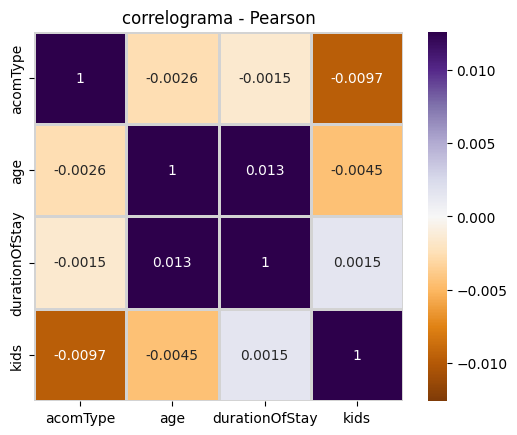

In [28]:
corr = dt_encoded[['acomType','age','durationOfStay','kids']].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Draw the heatmap with the mask and correct aspect ratio
vmax = np.abs(corr.values[~mask]).max()
sns.heatmap(corr, cmap=plt.cm.PuOr, vmin=-vmax, vmax=vmax,
            square=True, linecolor="lightgray", linewidths=1, ax=ax, annot=True)
plt.title('correlograma - Pearson')
plt.show()

La V de Crammer se usa para medir asociación entre dos variables categóricas, toma valores del 0 al , donde 0 significa no asociación y 1 es asociación perfecta

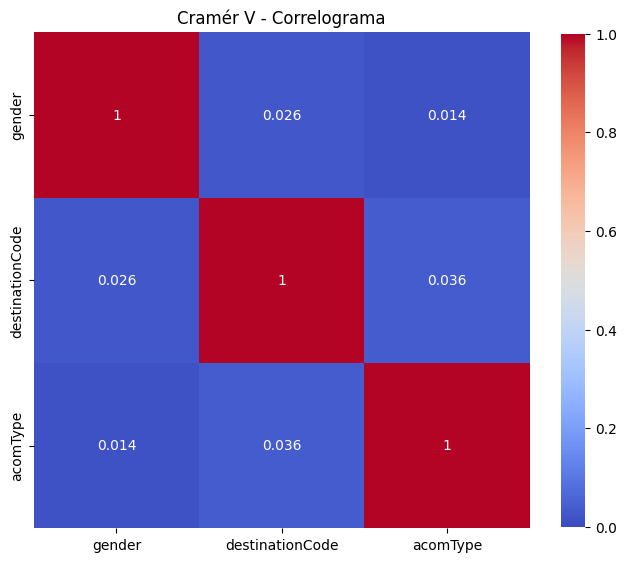

In [29]:
categorical_columns = [col for col in train_no_na.columns if col not in ['age','durationOfStay','id','kids']]
df_corr_cat = train_no_na[categorical_columns]

correlation_matrix = create_cramers_correlation_matrix(df_corr_cat)

# Plot correlogram
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, vmin = 0, vmax = 1,
            cmap='coolwarm', square=True, cbar_kws={'shrink': .8},
            linecolor="lightgray")
plt.title("Cramér V - Correlograma")
plt.show()

A partir de las correlaciones, no parece existir correlación lineal entre la variable objetivo `acomType` y ninguna otra variable

# 3. Modelado

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier



## 3.1 Estandarizar

Para asegurarnos que los datos númericos estén en escalas comparables y que pueden crear ruido en el modelo se estandarizan.

In [31]:
scaler = StandardScaler()

numerical_features = ['age','durationOfStay']

dt_encoded[numerical_features] = scaler.fit_transform(dt_encoded[numerical_features])


## 3.2 Splits & Kfolds

In [32]:
y = dt_encoded['acomType']
X = dt_encoded.drop('acomType', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 3.3 Multiple Models

In [33]:
random_state = 42

# Modelos
classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    LinearDiscriminantAnalysis(),
    XGBClassifier(random_state=random_state, learning_rate=0.1)
]

# Cross-validation
cv_results = []

# Run cross-validation for each classifier
for classifier in classifiers:
    cv_result = cross_val_score(classifier, X_train, y=y_train, scoring="accuracy", cv=kfolds, n_jobs=4)
    cv_results.append(cv_result)

# Calculate mean and standard deviation for each classifier's results
cv_means = [cv_result.mean() for cv_result in cv_results]
cv_std = [cv_result.std() for cv_result in cv_results]

# Create DataFrame for results
cv_res = pd.DataFrame({
    "CrossValMeans": cv_means,
    "CrossValerrors": cv_std,
    "Algorithm": [
        "SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees",
        "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors",
        "LogisticRegression", "LinearDiscriminantAnalysis", "XGBoost"
    ]
})


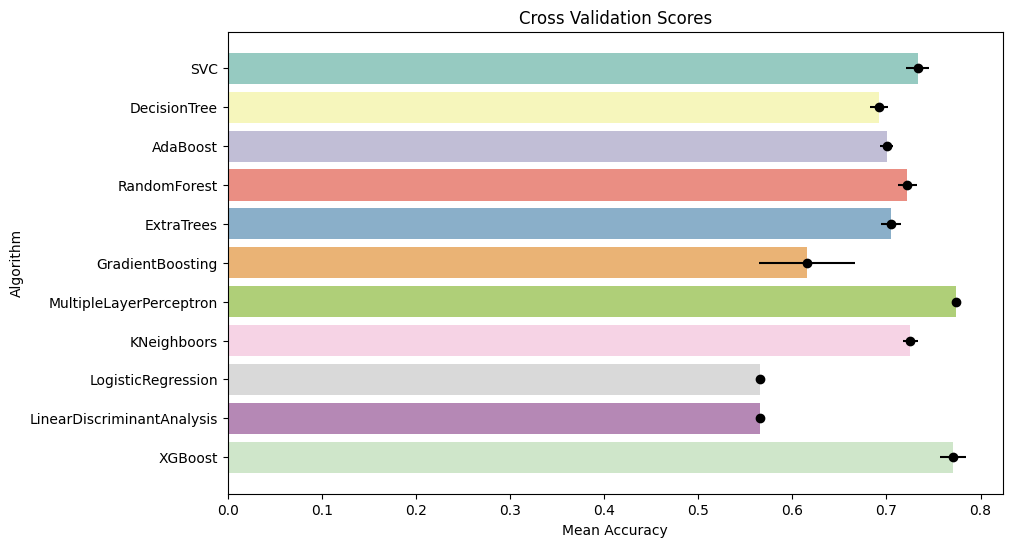

In [34]:
# Plot the cross-validation results
plt.figure(figsize=(10, 6))
g = sns.barplot(
    x="CrossValMeans",
    y="Algorithm",
    data=cv_res,
    palette="Set3",
    orient="h"
)

# Add error bars manually
for index, row in cv_res.iterrows():
    g.errorbar(
        x=row["CrossValMeans"],
        y=index,
        xerr=row["CrossValerrors"],
        fmt='o', color='black'
    )

g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores")
plt.show()

Los modelos con mejores méticas de ajuste son el Multiple Layer Perceptron, RandomForest y el XGboost, pueden ser candidatos para un ensamble. 

tomemos el ejemplo del XGBoost para hacer tuneo de hiperparámetros

## 3.4 Hyperparameter Tuning: XGBoost

In [35]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Instantiate the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state = 42)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfolds,
    verbose=1,
    n_jobs=-1,
)

# Run the grid search
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [44]:
best_xgb = grid_search.best_estimator_

y_preds = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

## 3.5 Ajuste

In [46]:

accuracy = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.7854
Precision: 0.8335
Recall: 0.7782
F1 Score: 0.8049
ROC AUC: 0.8230


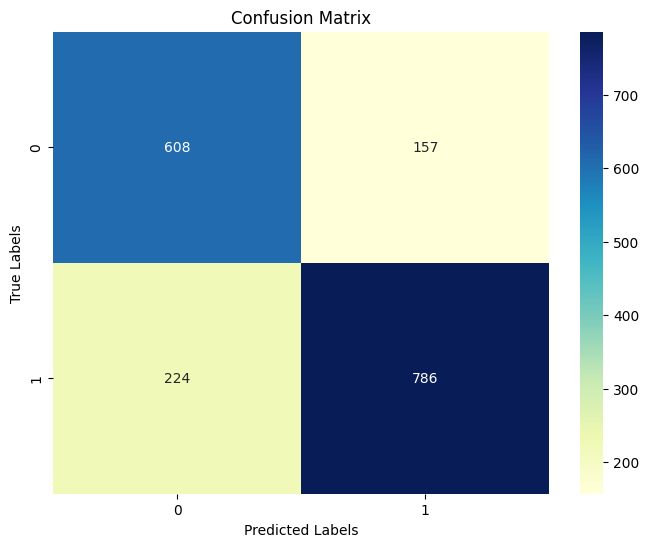

In [42]:
# Matríz de Confusión

cm = confusion_matrix(y_test, y_preds)
     
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
        

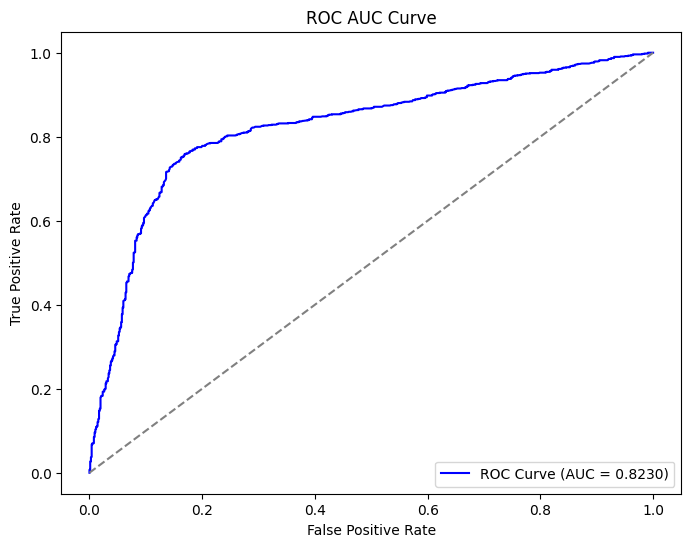

In [47]:
# 3. Plot ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend(loc="lower right")
plt.show()


## 3.6 Importancias

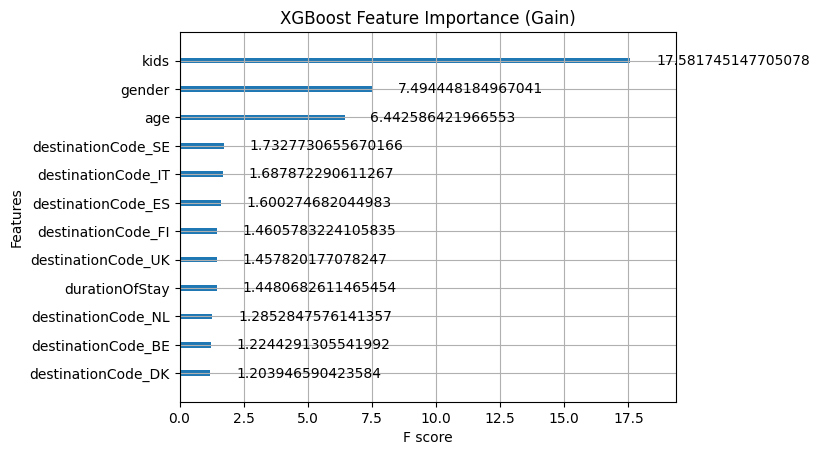

In [54]:
xgb.plot_importance(best_xgb, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

 ## 3.8 Predicciones

Preparamos los datos

In [101]:

dt_fcast_prep = (
    dt_fcast
    .set_index('id')
    .rename(columns = {
        'Age':'age'
    })
    .drop('AcomType', axis = 1)
    .dropna()
    .copy()
)


# Encoding
dt_fcast_prep['gender'] = np.where(dt_fcast_prep['gender'] == 'F', 1, 0)

categorical_features = [col for col in dt_fcast_prep.columns if col not in ['age','durationOfStay','kids', 'gender']]

dt_fcast_prep = pd.get_dummies(dt_fcast_prep, 
                            columns=categorical_features,
                            dtype=int)

# Estandarizar
numerical_features = ['age','durationOfStay']

dt_fcast_prep[numerical_features] = scaler.fit_transform(dt_fcast_prep[numerical_features])

Prediction

In [102]:
preds = label_encoder.inverse_transform(best_xgb.predict(dt_fcast_prep))

In [114]:
df_results = dt_fcast_prep.reset_index().copy()
df_results['AcomType'] = preds
df_results = df_results[['id','AcomType']]

In [118]:
final_df = (
    df_results
    .merge(dt_fcast.drop('AcomType',axis = 1), how='left', on = 'id')
)

In [119]:
final_df

,id,AcomType,durationOfStay,gender,Age,kids,destinationCode
0,1013319,Apt,2,F,38.0,0.0,BE
1,1009485,Hotel,6,M,37.0,0.0,ES
2,1002725,Apt,1,M,37.0,1.0,ES
3,1001133,Hotel,5,F,50.0,0.0,UK
4,1000794,Apt,4,F,42.0,1.0,DK
...,...,...,...,...,...,...,...
3074,1000373,Apt,5,F,48.0,1.0,FI
3075,1009344,Hotel,6,M,37.0,0.0,SE
3076,1002596,Hotel,4,M,42.0,1.0,UK
3077,1000615,Apt,4,M,48.0,0.0,UK
